In [1]:
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *

data = {
    'x1': load_data('../stats/fpm_4_2D_x1.json'),
    'x4': load_data('../stats/fpm_4_2D_x2.json'),
    'x9': load_data('../stats/fpm_4_2D_x3.json'),
    'x16': load_data('../stats/fpm_4_2D_x4.json'),
    'x25': load_data('../stats/fpm_4_2D_x5.json'),
    'x36': load_data('../stats/fpm_4_2D_x6.json'),
}

/home/porepy/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:14: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import trange  # type: ignore


In [2]:
shape = [3, 2]
figsize = (12, 6)

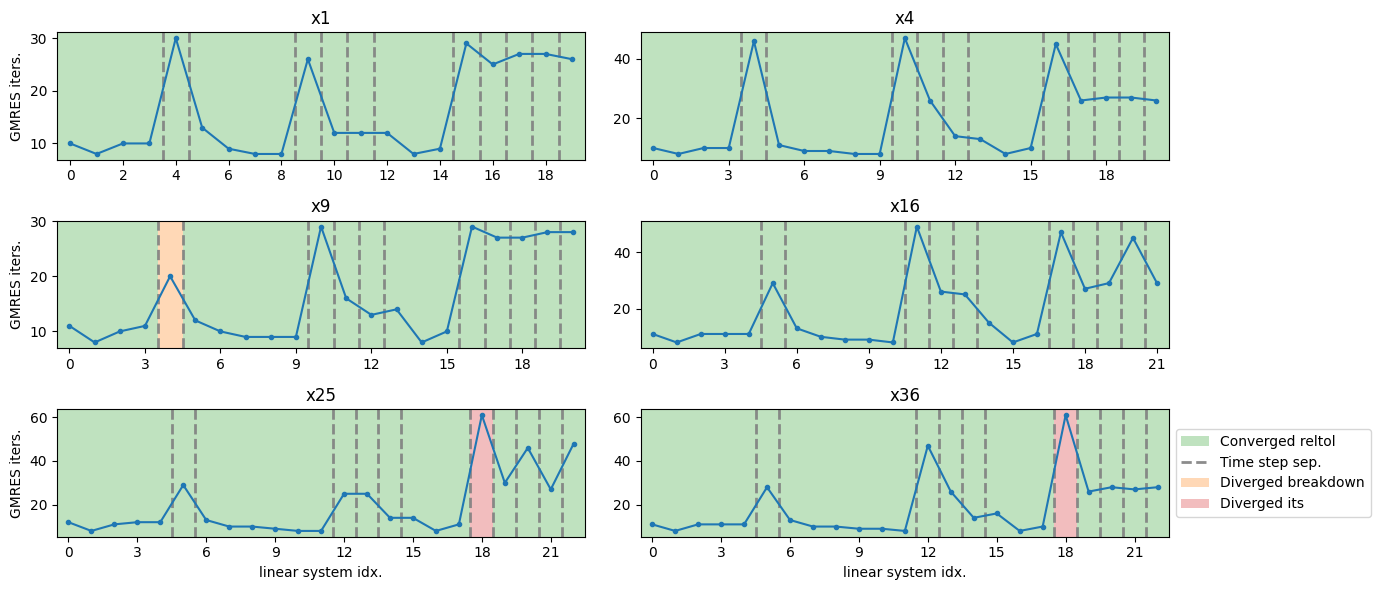

In [3]:
def render_element(entry: Sequence[TimeStepStats]):
    color_converged_reason(entry)
    color_time_steps(entry, fill=False, legend=True)
    plt.gca().grid(False)
    plt.plot(get_gmres_iterations(entry), marker='.')

plot_grid(data, render_element, shape=shape, figsize=figsize, legend=True)

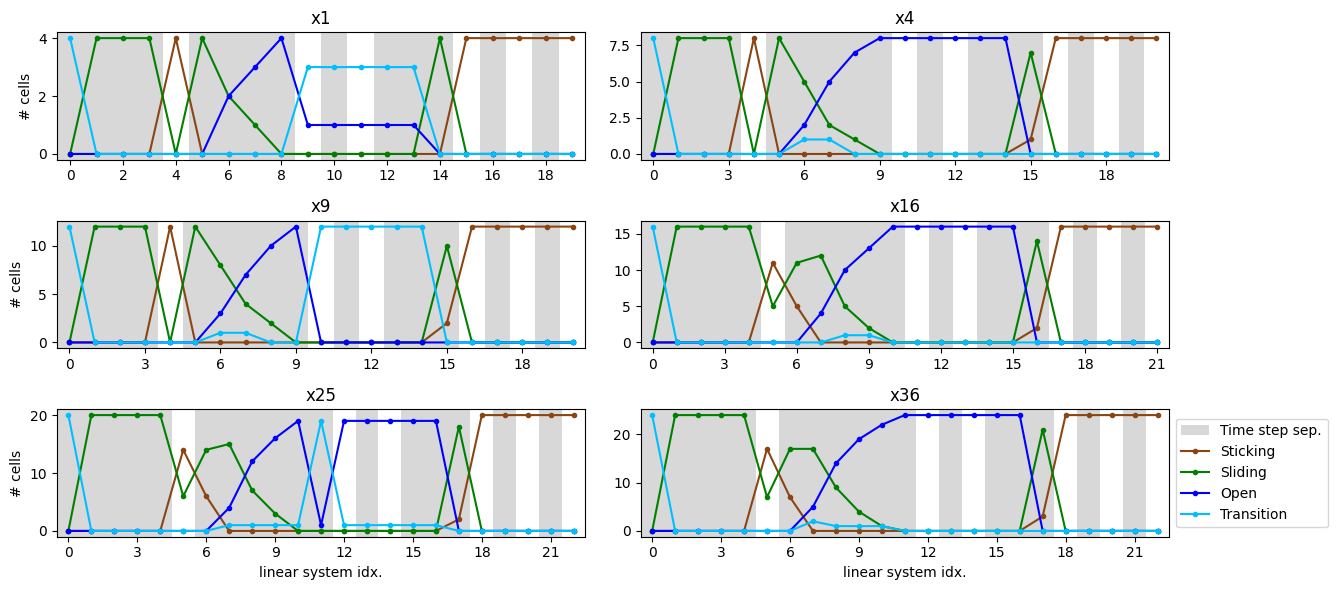

In [4]:
def render_element(entry: Sequence[TimeStepStats]):
    st, sl, op, tr = get_num_sticking_sliding_open_transition(entry)
    color_time_steps(entry, fill=True, grid=False, legend=True)
    plt.plot(st, label='Sticking', marker='.', color=COLOR_STICKING)
    plt.plot(sl, label='Sliding', marker='.', color=COLOR_SLIDING)
    plt.plot(op, label='Open', marker='.', color=COLOR_OPEN)
    plt.plot(tr, label='Transition', marker='.', color=COLOR_TRANSITION)

plot_grid(data, render_element, shape=shape, figsize=figsize, ylabel='# cells')

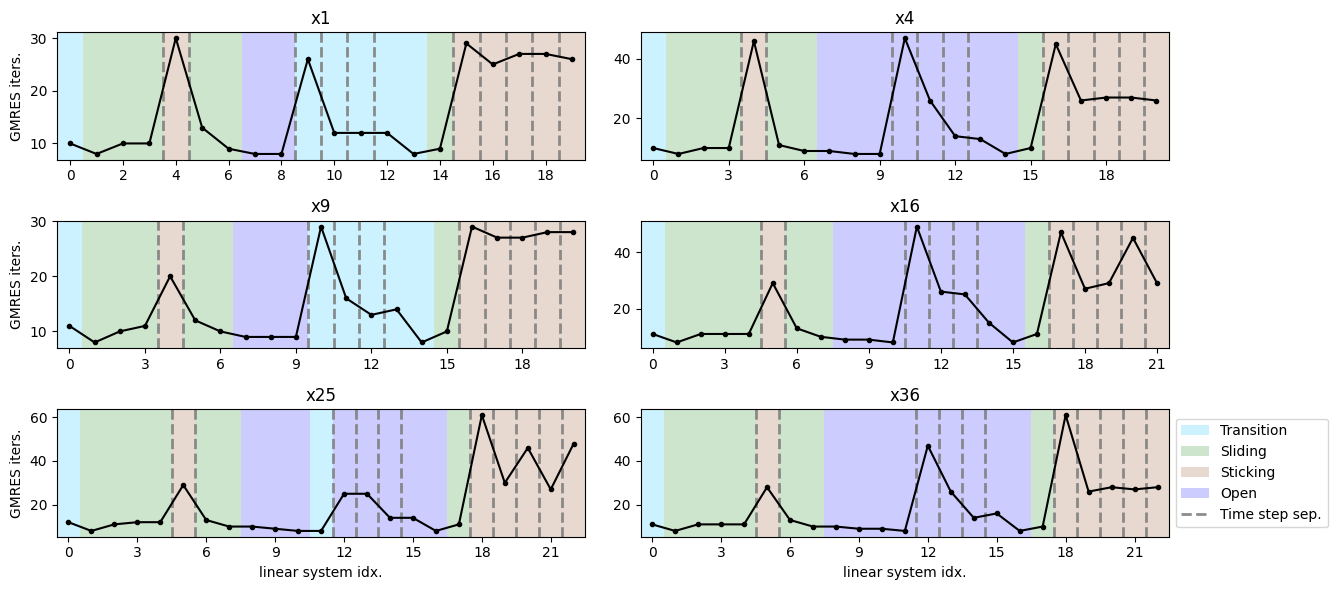

In [5]:
def render_element(entry: Sequence[TimeStepStats]):
    color_sticking_sliding_open_transition(entry)
    color_time_steps(entry, fill=False, legend=True)
    plt.gca().grid(False)
    plt.plot(get_gmres_iterations(entry), marker='.', color='black')
    # plt.ylim(top=15)

plot_grid(data, render_element, shape=shape, figsize=figsize, legend=True)

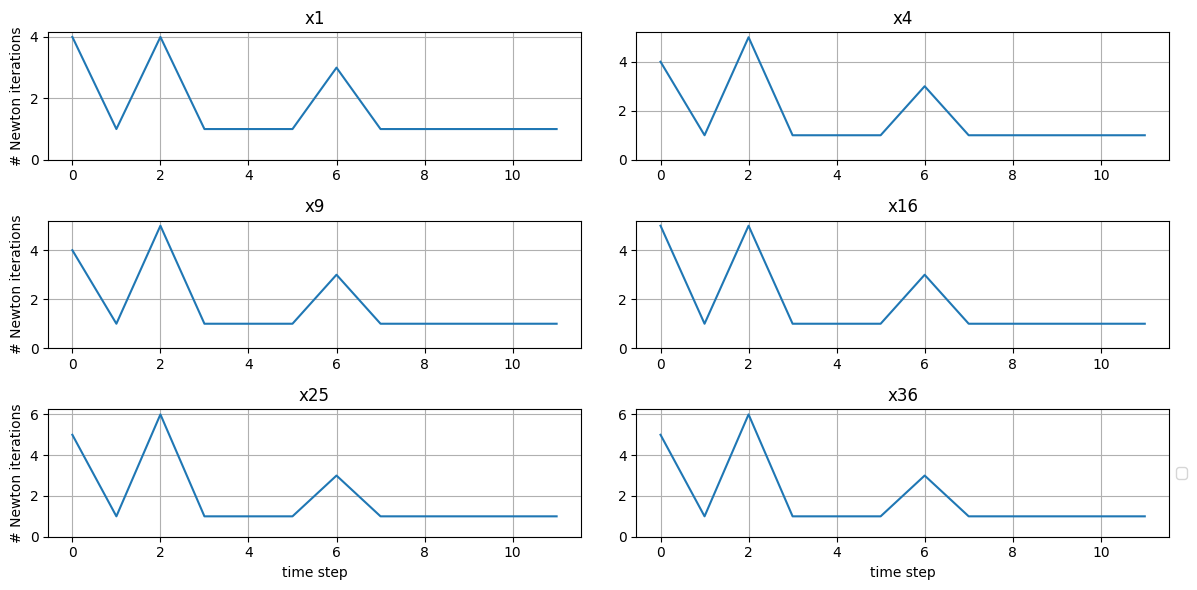

In [6]:
def render_element(entry: Sequence[TimeStepStats]):
    plt.plot(get_newton_iterations(entry))
    plt.ylim(bottom=0)
    plt.grid()

plot_grid(data, render_element, shape=shape, figsize=figsize, ylabel='# Newton iterations', xlabel='time step')

Text(0.5, 0, 'Simulation time, s')

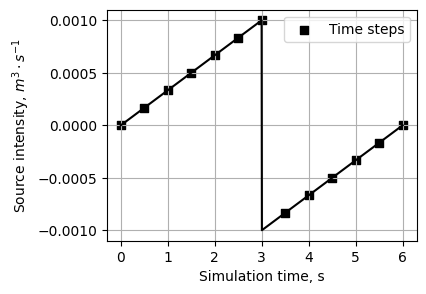

In [7]:
from fpm_4_2D import make_model

model = make_model(cell_size_multiplier=1)
model.prepare_simulation()
source = []
t_list = np.linspace(0, 6, 13, endpoint=True)
for t in t_list:
    source.append(model.get_source_intensity(t))

source_fine = []
t_list_fine = np.linspace(0, 6, 1000, endpoint=True)
for t in t_list_fine:
    source_fine.append(model.get_source_intensity(t))

plt.figure(figsize=(4, 3))
plt.plot(t_list_fine, source_fine, color='black')
plt.scatter(t_list, source, marker='s', label='Time steps', color='black')
plt.grid()
plt.legend()
plt.ylabel(r'Source intensity, $m^3 \cdot s^{-1}$')
plt.xlabel('Simulation time, s')

# Testing bad matrix

In [160]:
assert False

AssertionError: 

In [49]:
from fpm_4_2D import make_model

model = make_model(cell_size_multiplier=3)
model.prepare_simulation()
model.before_nonlinear_loop()
model.before_nonlinear_iteration()
model._initialize_solver()


num sticking: 0
num sliding: 0
num open: 0
num transition: 12


In [50]:
mat_idx = 4
entry = data['x9']
print(get_gmres_iterations(entry)[mat_idx])
mat, rhs, state, iterate, dt = load_matrix_rhs_state_iterate_dt(entry, mat_idx)

20


In [51]:
model.linear_system = mat, rhs
model.equation_system.set_variable_values(iterate, iterate_index=0)
model.equation_system.set_variable_values(state, time_step_index=0)  # 1

model.ad_time_step.set_value(dt)
st, sl, op, tr = model.sticking_sliding_open_transition()
print(sum(st))
print(sum(sl))
print(sum(op))
print(sum(tr))

12
0
0
0


/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


Solve  took: 0.56
True residual permuted: 0.4977346263682934
True residual: 0.5789253579600068
PETSc Converged Reason: -5
lambda min: 0.6650755593371793


{'mat_Q': BlockMatrixStorage of shape (6534, 6534) with 246391 elements with 6x6 active groups}

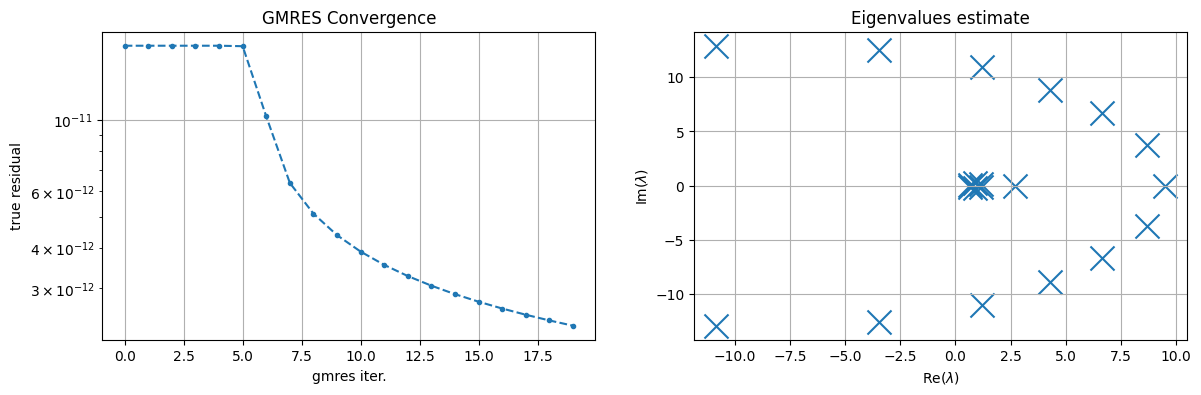

In [52]:
sol = None
schema = model._prepare_solver()
solve_petsc_new(model.bmat, schema, rhs_global=rhs, Qleft=model.Qleft, Qright=model.Qright, pc_side='right', tol=1e-10)

Solve  took: 0.73
True residual permuted: 5.5907840866798925e-09
True residual: 0.16916107933478775
PETSc Converged Reason: 2


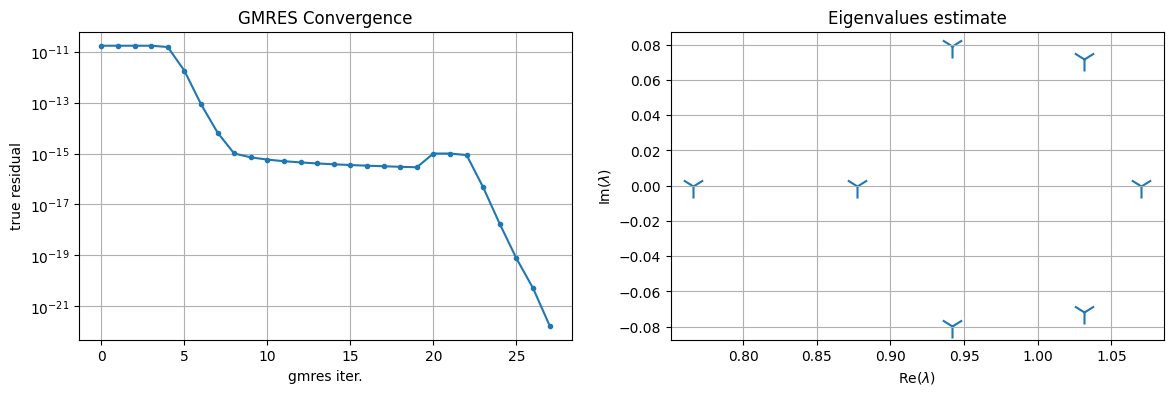

In [69]:
from block_matrix import SolveSchema, make_solver
from mat_utils import *
from preconditioner_mech import make_J44_inv_bdiag
from fixed_stress import *

schema = SolveSchema(
    groups=[4],
    solve=lambda bmat: inv_block_diag(mat=bmat[[4]].mat, nd=model.nd),
    # only_complement=True,
    complement=SolveSchema(
        groups=[3],
        solve=lambda bmat: PetscILU(bmat[[3]].mat),
        invertor=lambda bmat: extract_diag_inv(bmat[[3]].mat),
        # only_complement=True,
        complement=SolveSchema(
            groups=[1, 5],
            solve=lambda bmat: PetscAMGMechanics(mat=bmat[[1, 5]].mat, dim=model.nd),
            # invertor='direct',
            # invertor=lambda bmat: tmp.mat,
            # invertor=lambda bmat: make_fs_experimental(model, bmat).mat,
            # invertor=lambda bmat: make_fs_experimental(model, bmat).mat,
            # invertor=lambda bmat: get_fixed_stress_stabilization(model),
            invertor=lambda bmat: get_fs_fractures_analytical(model),
            # invertor=lambda bmat: get_fs_contact_analytical(model) * 67,

            invertor_type="physical",
            complement=SolveSchema(
                groups=[2],
                solve=lambda bmat: PetscAMGFlow(mat=bmat[[2]].mat),
            ),
        ),
    ),
)

res = solve_petsc_new(
    model.bmat,
    schema,
    Qleft=model.Qleft,
    Qright=model.Qright,
    rhs_global=rhs,
    pc_side="right",
    tol=1e-10,
    logx_eigs=False,
)

In [54]:
Jmech_orig = model.bmat[[1,5]]
Jmech_orig_inv = inv(Jmech_orig.mat)

In [55]:
J = res['mat_Q']
Jmech = J[[1,5]].copy()
Jmech_inv = inv(Jmech.mat)
# Jmech.mat -= Jmech_orig.mat
# Jmech.color_spy()

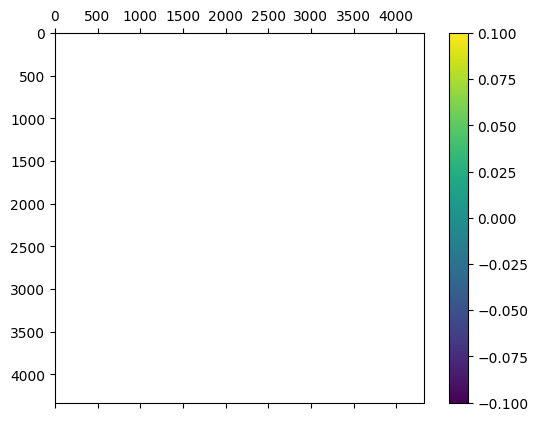

In [56]:
plot_mat(Jmech_inv - Jmech_orig_inv)
# plot_mat()

In [75]:
J = model.bmat.copy()
J55 = J[[5]].mat
J55_inv = inv_block_diag(J55, nd=model.nd)

cond(J55_inv @ J55_inv)

17.61237106710708

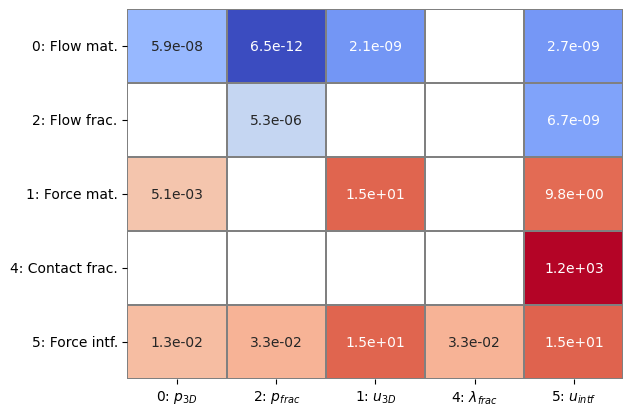

In [78]:
J[[0,2,1,4,5]].plot_max()